In [ ]:
import os
import json
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from itertools import combinations
import re


In [3]:
IMAGE_ROOT = "/data/ephemeral/home/data/train/DCM"
LABEL_ROOT = "/data/ephemeral/home/data/train/outputs_json"

In [4]:
pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}
jsons = {
    os.path.relpath(os.path.join(root, fname), start=LABEL_ROOT)
    for root, _dirs, files in os.walk(LABEL_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".json"
}
print(f'Train Image : {len(pngs)}, json : {len(jsons)}')

pngs = sorted(list(pngs))
jsons = sorted(list(jsons))
print(f'Image file name e.g.) {pngs[0]}\njson file name e.g.) {jsons[0]}')

Train Image : 800, json : 800
Image file name e.g.) ID001/image1661130828152_R.png
json file name e.g.) ID001/image1661130828152_R.json


In [5]:
def read_json_and_inspect(json_rel_path):
    json_path = os.path.join(LABEL_ROOT, json_rel_path)
    with open(json_path, 'r') as f:
        data = json.load(f)
    return data

# 첫 번째 JSON 파일 구조 확인
sample_json_path = jsons[0]
sample_data = read_json_and_inspect(sample_json_path)

print(f"File: {sample_json_path}")
print("Keys:", sample_data.keys())
# 'annotations' 키가 있는지, 내부 구조가 어떤지 확인용 출력
if 'annotations' in sample_data:
    print("First annotation example:", sample_data['annotations'][0])

File: ID001/image1661130828152_R.json
Keys: dict_keys(['annotations', 'attributes', 'file_id', 'filename', 'parent_path', 'last_modifier_id', 'metadata', 'last_workers'])
First annotation example: {'id': '30-f037db6e-aef2-4156-93e2-8de7cc97869c', 'type': 'poly_seg', 'attributes': {}, 'points': [[960, 2047], [960, 2046], [960, 2045], [960, 2044], [960, 2043], [960, 2042], [960, 2041], [959, 2041], [959, 2040], [959, 2039], [959, 2038], [959, 2037], [959, 2036], [959, 2035], [959, 2034], [959, 2033], [959, 2032], [959, 2031], [959, 2030], [959, 2029], [959, 2028], [959, 2027], [959, 2026], [959, 2025], [958, 2025], [958, 2024], [958, 2023], [958, 2022], [958, 2021], [958, 2020], [958, 2019], [958, 2018], [958, 2017], [958, 2016], [958, 2015], [958, 2014], [958, 2013], [958, 2012], [958, 2011], [958, 2010], [958, 2009], [958, 2008], [958, 2007], [958, 2006], [958, 2005], [957, 2005], [957, 2004], [957, 2003], [957, 2002], [957, 2001], [957, 2000], [957, 1999], [957, 1998], [957, 1997], [9

In [67]:
for idx,i in enumerate(jsons):
    if 'image1664241793733' in i:
        print(idx)

330


In [69]:
jsons[330]

'ID314/image1664241793733.json'

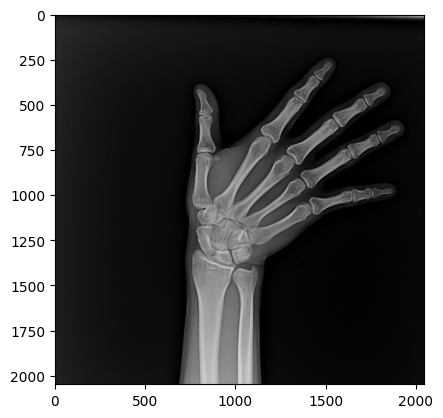

In [7]:
# img = cv2.imread(IMAGE_ROOT + '/' + pngs[0])
img = cv2.imread('/data/ephemeral/home/data/train/DCM/ID314/image1664241793733.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)

In [42]:
from glob import glob
img_list = []
dcm_list = glob('/data/ephemeral/home/data/train/DCM/*')
for d in dcm_list:
    for i in glob(d+'/*'):
        img_list.append(i)


In [11]:
import os, json
import cv2
import numpy as np
import matplotlib.pyplot as plt

IMG_PATH  = "/data/ephemeral/home/data/train/DCM/ID314/image1664241793733.png"
JSON_PATH = "/data/ephemeral/home/data/train/outputs_json/ID314/image1664241793733.json"
OUT_DIR   = "./debug_align_steps_ID314"
os.makedirs(OUT_DIR, exist_ok=True)

TARGET_LABEL = "finger-11"   # 중지
RADIUS_LABEL = "Radius"
ULNA_LABEL   = "Ulna"

img_bgr = cv2.imread(IMG_PATH)
assert img_bgr is not None, "image read failed"
img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
h, w = img.shape[:2]

with open(JSON_PATH, "r") as f:
    ann = json.load(f)

print("Loaded:", IMG_PATH)
print("Image:", img.shape, "Annotations:", len(ann["annotations"]))
print("OUT_DIR:", OUT_DIR)


Loaded: /data/ephemeral/home/data/train/DCM/ID314/image1664241793733.png
Image: (2048, 2048, 3) Annotations: 29
OUT_DIR: ./debug_align_steps_ID314


In [12]:
labels = sorted(set(a["label"] for a in ann["annotations"]))
print("labels:", labels)

f11 = next((a for a in ann["annotations"] if a["label"] == TARGET_LABEL), None)
assert f11 is not None, "❌ finger-11 not found"

r_ann = next((a for a in ann["annotations"] if a["label"] == RADIUS_LABEL), None)
u_ann = next((a for a in ann["annotations"] if a["label"] == ULNA_LABEL), None)

print("finger-11 points:", len(f11["points"]))
print("Radius exists:", r_ann is not None, "Ulna exists:", u_ann is not None)


labels: ['Capitate', 'Hamate', 'Lunate', 'Pisiform', 'Radius', 'Scaphoid', 'Trapezium', 'Trapezoid', 'Triquetrum', 'Ulna', 'finger-1', 'finger-10', 'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15', 'finger-16', 'finger-17', 'finger-18', 'finger-19', 'finger-2', 'finger-3', 'finger-4', 'finger-5', 'finger-6', 'finger-7', 'finger-8', 'finger-9']
finger-11 points: 39
Radius exists: True Ulna exists: True


In [13]:
def polygon_to_mask(h, w, pts):
    m = np.zeros((h, w), np.uint8)
    pts = np.array(pts, np.int32).reshape(-1,1,2)
    cv2.fillPoly(m, [pts], 255)
    return m

def get_largest_contour(mask):
    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        return None
    return max(cnts, key=cv2.contourArea)

def obb_from_contour(cnt):
    # returns (box_pts, angle_deg, (cx,cy), (bw,bh))
    rect = cv2.minAreaRect(cnt)
    (cx, cy), (bw, bh), ang = rect
    # OpenCV angle 보정: 장축이 세로가 되게 angle 정규화
    if bw >= bh:
        ang += 90
        bw, bh = bh, bw
    box = cv2.boxPoints(((cx,cy),(bw,bh), ang))
    box = np.int32(box)
    return box, float(ang), (float(cx), float(cy)), (float(bw), float(bh))

def rotate_image(img, pivot, deg):
    M = cv2.getRotationMatrix2D(pivot, deg, 1.0)
    out = cv2.warpAffine(
        img, M, (w, h),
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=(0,0,0)
    )
    return out, M

def rotate_points(pts, M):
    pts = np.array(pts, np.float32)
    pts_h = np.hstack([pts, np.ones((len(pts),1), np.float32)])
    out = pts_h @ M.T
    return out.tolist()

def draw_polygons(img_rgb, ann_dict, color=(0,255,0), highlight_label=None, highlight_color=(255,0,0), thickness=1):
    # img_rgb: RGB
    vis = img_rgb.copy()
    for a in ann_dict["annotations"]:
        pts = np.array(a["points"], np.int32)
        c = highlight_color if (highlight_label and a["label"]==highlight_label) else color
        cv2.polylines(vis, [pts], True, c, thickness)
    return vis

def save_show(path, img_rgb, title=None, figsize=(8,8)):
    plt.figure(figsize=figsize)
    plt.imshow(img_rgb, cmap=None)
    plt.axis("off")
    if title: plt.title(title)
    plt.tight_layout()
    plt.savefig(path, bbox_inches="tight", pad_inches=0)
    plt.show()
    print("saved:", path)


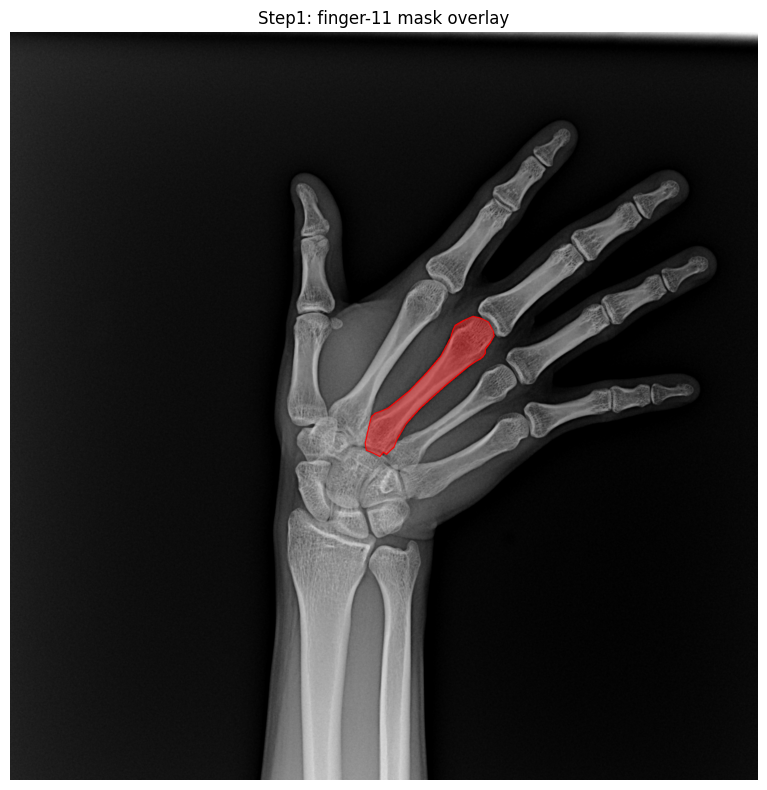

saved: ./debug_align_steps_ID314/step1_f11_mask.png


In [14]:
f11_mask = polygon_to_mask(h, w, f11["points"])
cnt = get_largest_contour(f11_mask)
assert cnt is not None, "❌ finger-11 contour not found"

# 시각화
vis = img.copy()
# finger-11 폴리곤
vis = draw_polygons(vis, {"annotations":[f11]}, color=(0,255,0), highlight_label=TARGET_LABEL, highlight_color=(255,0,0), thickness=2)

# 마스크 overlay (반투명)
overlay = vis.copy()
overlay[f11_mask>0] = (overlay[f11_mask>0]*0.6 + np.array([255,0,0])*0.4).astype(np.uint8)

save_show(f"{OUT_DIR}/step1_f11_mask.png", overlay, "Step1: finger-11 mask overlay")


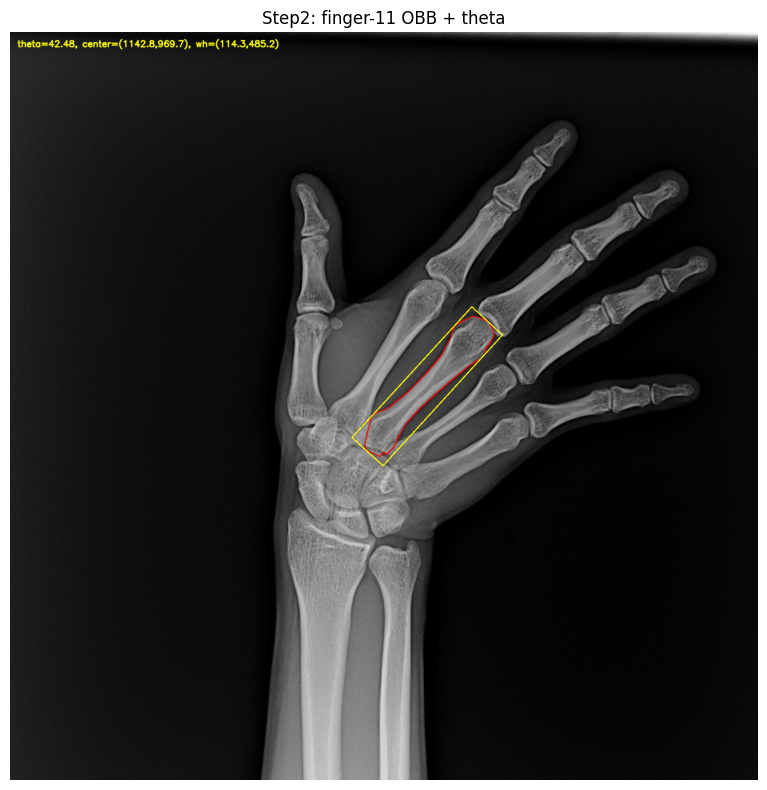

saved: ./debug_align_steps_ID314/step2_f11_obb.png
Step2 theta: 42.47916793823242


In [15]:
box, theta, cxy, wh = obb_from_contour(cnt)

vis = img.copy()
# finger-11 polygon + OBB box
vis = draw_polygons(vis, {"annotations":[f11]}, color=(0,255,0), highlight_label=TARGET_LABEL, highlight_color=(255,0,0), thickness=2)
cv2.polylines(vis, [box], True, (255,255,0), 2)  # yellow box

# 텍스트
txt = f"theta={theta:.2f}, center=({cxy[0]:.1f},{cxy[1]:.1f}), wh=({wh[0]:.1f},{wh[1]:.1f})"
cv2.putText(vis, txt, (20,40), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,0), 2, cv2.LINE_AA)

save_show(f"{OUT_DIR}/step2_f11_obb.png", vis, "Step2: finger-11 OBB + theta")
print("Step2 theta:", theta)


In [16]:
rot = 90 - theta
print("Step3 rot(deg) =", rot)


Step3 rot(deg) = 47.52083206176758


pivots: [('pivot1_f11', (1142.79296875, 969.7260131835938)), ('pivot2_wrist', (936.2093505859375, 1355.533447265625)), ('pivot3_carpal', (936.2307739257812, 1239.9307861328125))]


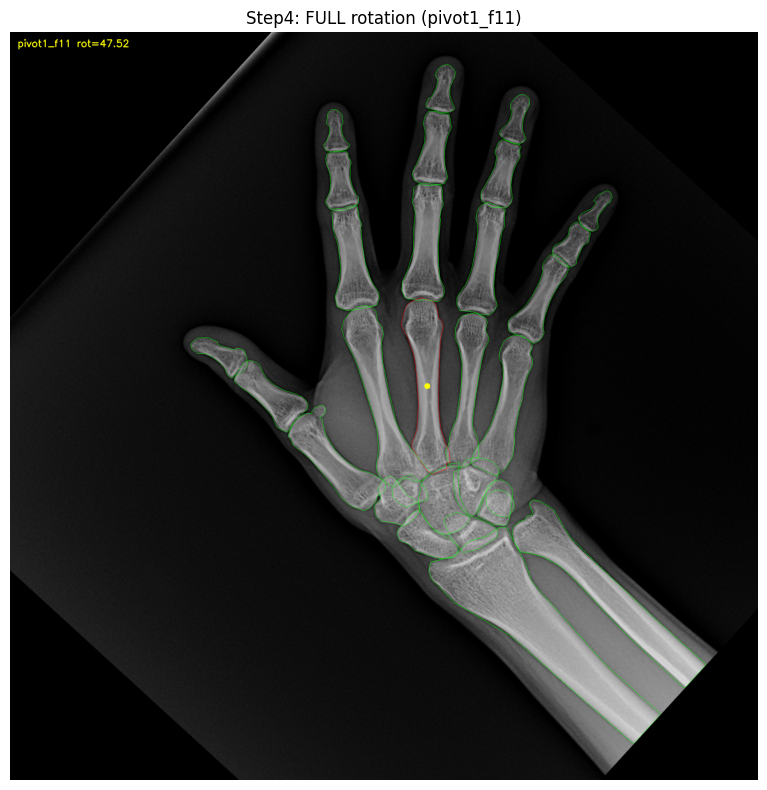

saved: ./debug_align_steps_ID314/step4_fullrot_pivot1_f11.png


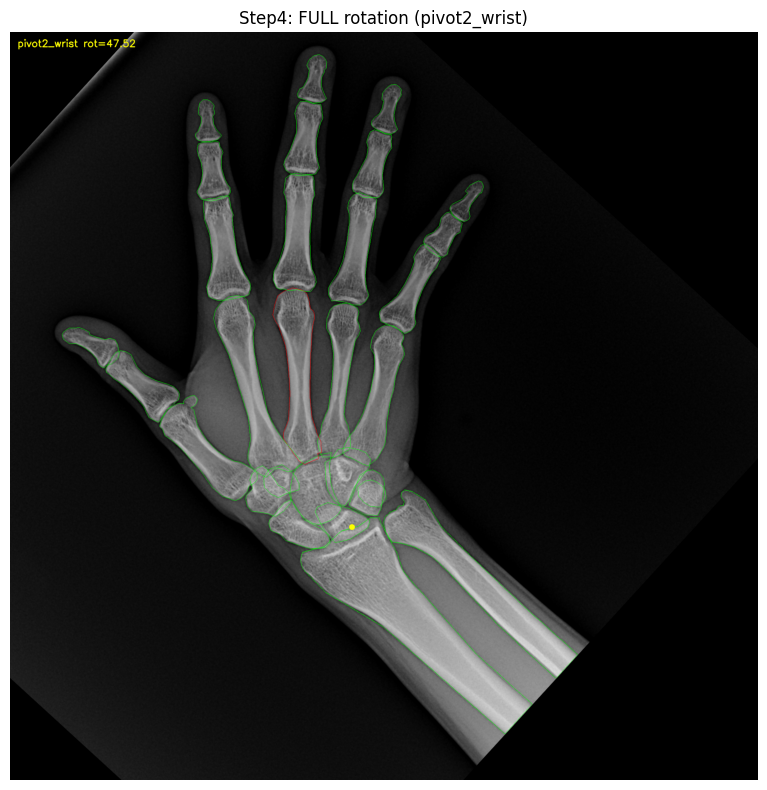

saved: ./debug_align_steps_ID314/step4_fullrot_pivot2_wrist.png


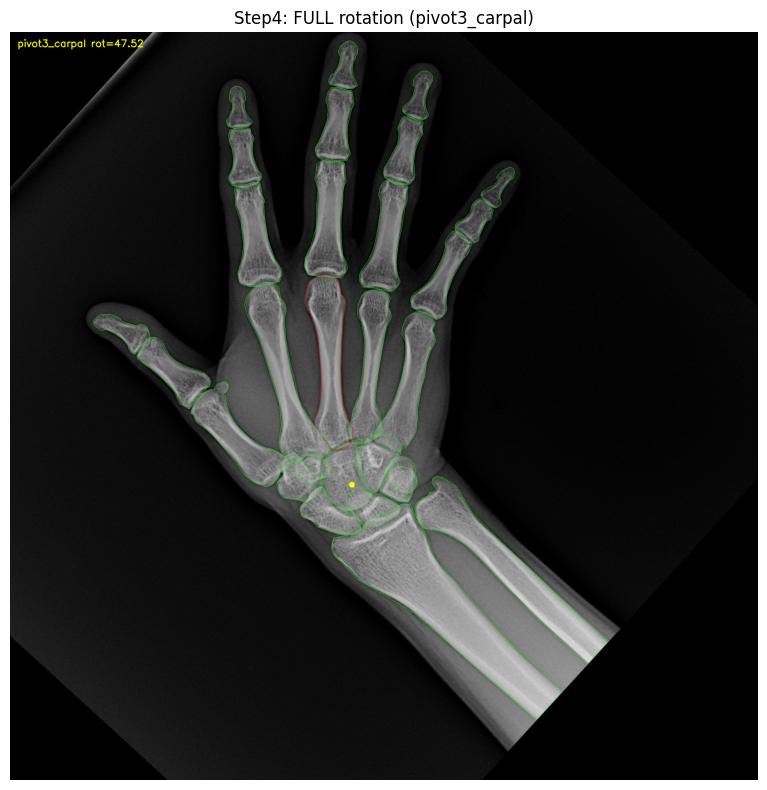

saved: ./debug_align_steps_ID314/step4_fullrot_pivot3_carpal.png


In [17]:
def centroid_from_poly(label):
    a = next((x for x in ann["annotations"] if x["label"]==label), None)
    if a is None:
        return None
    m = polygon_to_mask(h,w,a["points"])
    M = cv2.moments(m, binaryImage=True)
    if M["m00"] == 0: return None
    return (M["m10"]/M["m00"], M["m01"]/M["m00"])

# pivot 후보1: finger-11 중심
pivot1 = cxy

# pivot 후보2: Radius/Ulna 손목 쪽 끝단(상단 5%) 평균 중간
def wrist_pivot_from_ru():
    def top_point(label):
        a = next((x for x in ann["annotations"] if x["label"]==label), None)
        if a is None: return None
        pts = np.array(a["points"], np.float32)
        y = pts[:,1]
        thr = np.percentile(y, 5)
        top = pts[y <= thr]
        return top.mean(0) if len(top) else pts.mean(0)
    r = top_point(RADIUS_LABEL)
    u = top_point(ULNA_LABEL)
    if r is None or u is None:
        return (w/2, h/2)
    p = (r+u)/2
    return (float(p[0]), float(p[1]))

pivot2 = wrist_pivot_from_ru()

# pivot 후보3: 손목뼈(손등: carpal 8개) 중심
carpal_labels = ["Scaphoid","Lunate","Triquetrum","Pisiform","Trapezium","Trapezoid","Capitate","Hamate"]
carpal_pts = []
for lab in carpal_labels:
    a = next((x for x in ann["annotations"] if x["label"]==lab), None)
    if a is not None:
        carpal_pts.append(np.array(a["points"], np.float32))
pivot3 = (w/2, h/2) if not carpal_pts else tuple(np.vstack(carpal_pts).mean(0).tolist())

pivots = [("pivot1_f11", pivot1), ("pivot2_wrist", pivot2), ("pivot3_carpal", pivot3)]
print("pivots:", pivots)

for name, pv in pivots:
    rot_img, M = rotate_image(img, pv, rot)

    # json의 모든 폴리곤도 같이 회전해서 시각화 (전후 비교 핵심)
    ann_rot = {"annotations":[]}
    for a in ann["annotations"]:
        a2 = dict(a)
        a2["points"] = rotate_points(a["points"], M)
        ann_rot["annotations"].append(a2)

    vis = draw_polygons(rot_img, ann_rot, color=(0,255,0), highlight_label=TARGET_LABEL, highlight_color=(255,0,0), thickness=1)
    # pivot 표시
    cv2.circle(vis, (int(pv[0]), int(pv[1])), 8, (255,255,0), -1)
    cv2.putText(vis, f"{name} rot={rot:.2f}", (20,40), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,255,0), 2)

    save_show(f"{OUT_DIR}/step4_fullrot_{name}.png", vis, f"Step4: FULL rotation ({name})")


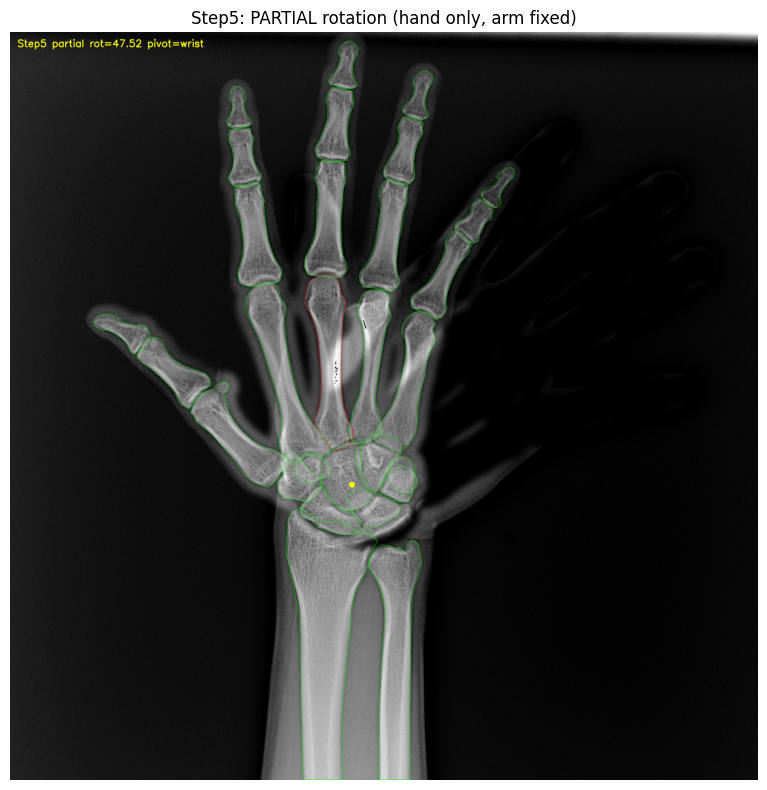

saved: ./debug_align_steps_ID314/step5_partial_rotate.png


In [21]:
def build_hand_soft_alpha(exclude=(RADIUS_LABEL, ULNA_LABEL), dilate=55, blur=51):
    m = np.zeros((h,w), np.uint8)
    for a in ann["annotations"]:
        if a["label"] in exclude:
            continue
        m |= polygon_to_mask(h,w,a["points"])
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (dilate,dilate))
    m = cv2.dilate(m, k, 1)
    if blur % 2 == 0: blur += 1
    alpha = cv2.GaussianBlur(m.astype(np.float32)/255.0, (blur,blur), 0)
    return np.clip(alpha, 0, 1)

# Step4에서 선택한 pivot을 고정: 보통 pivot2_wrist
pivot = pivot3

alpha = build_hand_soft_alpha()
rot_img, M = rotate_image(img, pivot, rot)
alpha_r = cv2.warpAffine(alpha, M, (w,h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)

# 블렌딩
# out = (img*(1-alpha_r[...,None]) + rot_img*alpha_r[...,None]).astype(np.uint8)


# 1) 원본에서 손 영역 제거
background = img * (1 - alpha[...,None])

# 2) 회전된 손 추출
rotated_hand = rot_img * alpha_r[...,None]

# 3) 합성
out = (background + rotated_hand).astype(np.uint8)



# 폴리곤도 "손만 회전" 적용
ann_part = {"annotations":[]}
for a in ann["annotations"]:
    a2 = dict(a)
    if a["label"] in [RADIUS_LABEL, ULNA_LABEL]:
        a2["points"] = a["points"]  # 고정
    else:
        a2["points"] = rotate_points(a["points"], M)
    ann_part["annotations"].append(a2)

vis = draw_polygons(out, ann_part, color=(0,255,0), highlight_label=TARGET_LABEL, highlight_color=(255,0,0), thickness=1)
cv2.circle(vis, (int(pivot[0]), int(pivot[1])), 8, (255,255,0), -1)
cv2.putText(vis, f"Step5 partial rot={rot:.2f} pivot=wrist", (20,40), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,255,0), 2)

save_show(f"{OUT_DIR}/step5_partial_rotate.png", vis, "Step5: PARTIAL rotation (hand only, arm fixed)")
